In [1]:
%cd /home/ltchen/gnnpp
import pandas as pd
import sys
import json
import copy
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
import shap
import matplotlib.pyplot as plt
from exploration.get_graphs_and_data import *
from utils.explainability_utils import *
from models.loss import *
from utils.plot import *
import seaborn as sns

/home/ltchen/gnnpp


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIRECTORY = os.getcwd()
print(DIRECTORY)
FIGUREPATH = os.path.join(DIRECTORY, 'figures/crpss_plots')
os.makedirs(FIGUREPATH, exist_ok=True)

/home/ltchen/gnnpp


## Compare DRN CRPS with GNN CRPS

In [21]:
LEADTIME = "120h"
DATASET = "rf"
GRAPH_NAME = "g5"


drn_model = pd.read_csv(f"leas_trained_models/drn_{LEADTIME}/{DATASET}_drn_{LEADTIME}_results.csv")
gnn_model = pd.read_csv(f"leas_trained_models/sum_stats_{LEADTIME}/{GRAPH_NAME}_{LEADTIME}/{DATASET}_{GRAPH_NAME}_{LEADTIME}_results.csv")
gnn_model["t2m"] = gnn_model["t2m"] + 273.15
gnn_model["mu"] = gnn_model["mu"] + 273.15

dfs = load_dataframes(leadtime=LEADTIME)
targets = dfs[f"test_{DATASET}"][1].dropna(axis=0)
gnn_model = gnn_model.dropna(axis=0)


[INFO] Dataframes exist. Will load pandas dataframes.


In [22]:
targets[f"crps_GNN_{GRAPH_NAME}"] = crps_no_avg(torch.tensor(gnn_model[["mu", "sigma"]].to_numpy()), torch.tensor(gnn_model["t2m"].to_numpy())).flatten().numpy()
targets["crps_DRN"] = crps_no_avg(torch.tensor(drn_model[["mu", "sigma"]].to_numpy()), torch.tensor(drn_model["t2m"].to_numpy())).flatten().numpy()

station_crps = targets.groupby("station_id")[[f"crps_GNN_{GRAPH_NAME}", "crps_DRN"]].mean().reset_index()
station_crps["crpss"] = 1 - (station_crps[f"crps_GNN_{GRAPH_NAME}"] / station_crps["crps_DRN"]) # =
stations = dfs["stations"]
stations["station_id"] = np.arange(0, len(stations))
stations = pd.merge(left=stations, right=station_crps, on="station_id")
stations

/tmp/ipykernel_966879/1395909528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets[f"crps_GNN_{GRAPH_NAME}"] = crps_no_avg(torch.tensor(gnn_model[["mu", "sigma"]].to_numpy()), torch.tensor(gnn_model["t2m"].to_numpy())).flatten().numpy()
/tmp/ipykernel_966879/1395909528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets["crps_DRN"] = crps_no_avg(torch.tensor(drn_model[["mu", "sigma"]].to_numpy()), torch.tensor(drn_model["t2m"].to_numpy())).flatten().numpy()


,station_id,lat,lon,altitude,orog,name,crps_GNN_g5,crps_DRN,crpss
0,0,52.928000,4.781000,1.2,-1.706008,De Kooy,1.001107,1.011153,0.009935
1,1,52.318000,4.790000,-3.3,-1.298122,Schiphol,1.076609,1.068882,-0.007229
2,2,53.241000,4.921000,10.8,0.333424,Vlieland,0.849763,0.849038,-0.000854
3,3,53.392000,5.346000,0.7,1.302155,Hoorn (Terschelling),1.051179,1.056873,0.005387
4,4,52.100000,5.180000,1.9,2.576800,De Bilt,1.223407,1.218459,-0.004061
...,...,...,...,...,...,...,...,...,...
104,115,45.786833,3.149333,331.0,521.714299,Clermont-Fd,1.264946,1.285726,0.016163
105,116,47.499168,9.746111,424.0,689.253673,Bregenz,1.162076,1.170882,0.007521
106,117,47.266666,9.600000,439.0,972.938723,Feldkirch,1.272708,1.327781,0.041477
107,118,47.255833,10.186111,1478.0,1752.460782,Warth,1.320967,1.307963,-0.009942


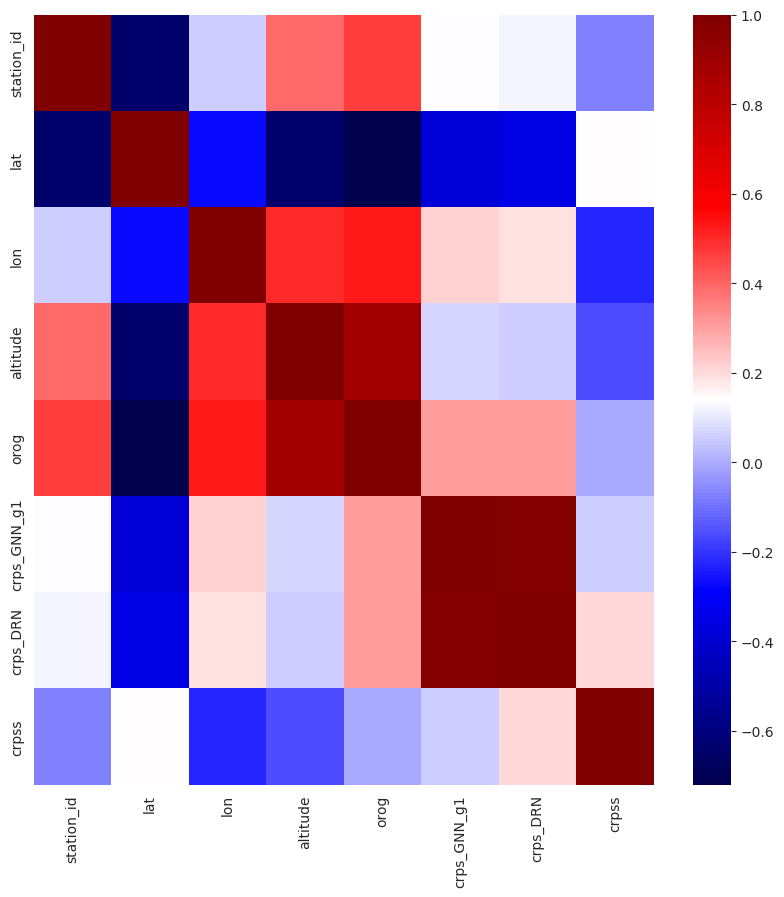

In [15]:
# is station crpss correlated with anything?
corr_mat = stations.corr(numeric_only=True)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=False, cmap="seismic")

plt.show()

In [14]:
import matplotlib as mpl
class MidpointNormalize(mpl.colors.Normalize):
    """ From: https://matplotlib.org/users/colormapnorms.html"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...

        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)

        vlargest = max( abs( self.vmax - self.midpoint ), abs( self.vmin - self.midpoint ) )
        x, y = [ self.midpoint - vlargest, self.midpoint, self.midpoint + vlargest], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

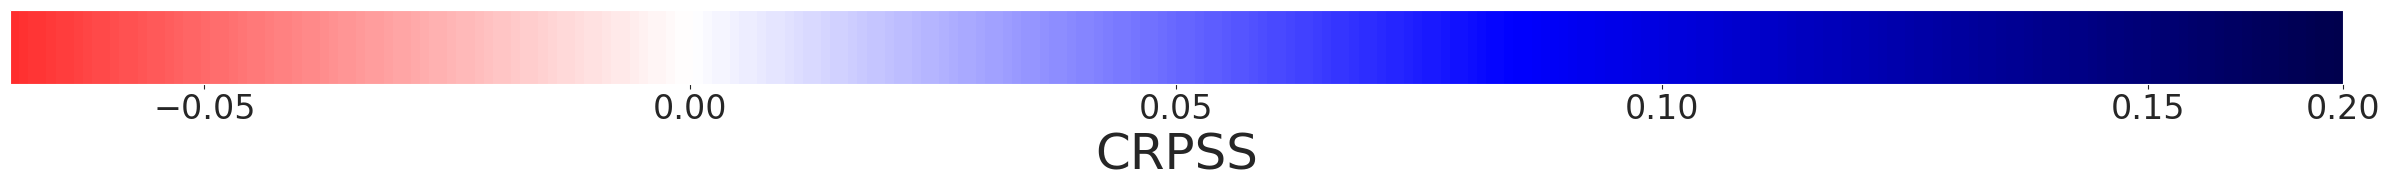

In [23]:
#cmap = "seismic_r"
# norm = MidpointNormalize(midpoint=0)
# sm_nodes = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# plot colormap on its own
cmap = plt.cm.seismic_r
# norm = mpl.colors.Normalize(vmin=-0.07, vmax=0.17)  # example limits
norm = MidpointNormalize(vmin=-0.07, vmax=0.17, midpoint=0)


sm_nodes = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm_nodes.set_array([])  # required for older matplotlib versions

fig, ax = plt.subplots(figsize=(24, 2))  # narrow & tall figure for vertical colorbar

cbar = fig.colorbar(sm_nodes, cax=ax, orientation='horizontal')
cbar.set_label('CRPSS', fontsize=36)
cbar.ax.tick_params(labelsize=24)

plt.tight_layout()
# plt.savefig(os.path.join(FIGUREPATH,"colorbar_crpss.pdf"), bbox_inches='tight')
plt.show()


<Figure size 1200x1000 with 0 Axes>

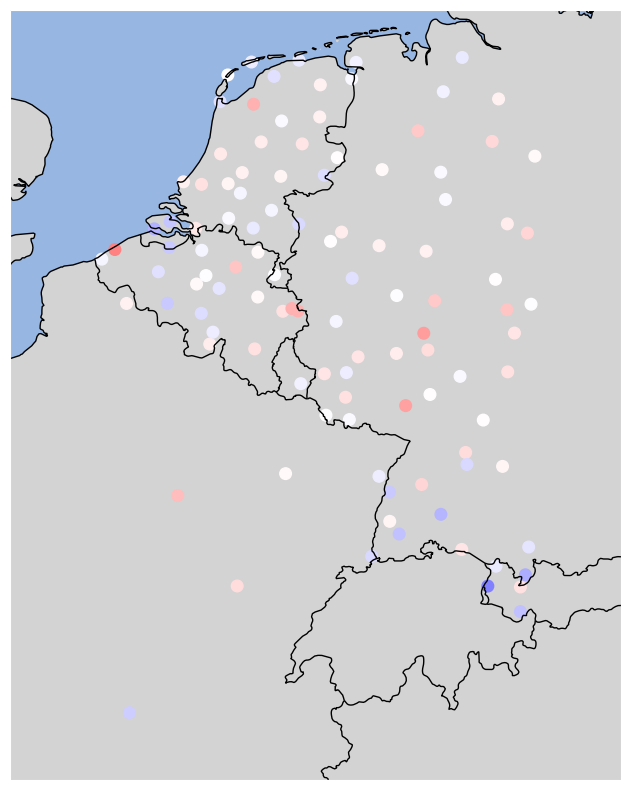

In [24]:
# one picture
fig = plt.figure(figsize=(12, 10))
ax = plot_map()
plot = ax.scatter(stations['lon'], stations['lat'], c=stations['crpss'], cmap=cmap, s=70, norm=norm)
# colbar = plt.colorbar(sm_nodes, ax=ax, aspect=30)
# colbar.set_ticks(colbar.get_ticks()[1:-1])
# colbar.ax.set_ylabel('CRPSS', rotation=270, labelpad=20)

## Fix the aspect ratio of the map
# lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
# ax.set_aspect(1 / np.cos(np.radians(lat_center)))
plt.savefig(os.path.join(FIGUREPATH, f"big_crpss{LEADTIME}_DRNvsGNN{GRAPH_NAME}_{DATASET}.pdf"), bbox_inches = 'tight')

In [3]:
stations_list = []
LEADTIME = "72h"
DATASET = "f"
graphs = ["g1", "g3", "g4", "g5"]

drn_model = pd.read_csv(f"leas_trained_models/drn_{LEADTIME}/{DATASET}_drn_{LEADTIME}_results.csv")
dfs = load_dataframes(leadtime=LEADTIME)
targets = dfs[f"test_{DATASET}"][1].dropna(axis=0)

for g in graphs:
    gnn_model = pd.read_csv(
        f"leas_trained_models/sum_stats_{LEADTIME}/{g}_{LEADTIME}/{DATASET}_{g}_{LEADTIME}_results.csv")
    gnn_model["t2m"] = gnn_model["t2m"] + 273.15
    gnn_model["mu"] = gnn_model["mu"] + 273.15
    gnn_model = gnn_model.dropna(axis=0)

    targets[f"crps_GNN_{g}"] = crps_no_avg(torch.tensor(gnn_model[["mu", "sigma"]].to_numpy()),
                                                torch.tensor(gnn_model["t2m"].to_numpy())).flatten().numpy()
    targets["crps_DRN"] = crps_no_avg(torch.tensor(drn_model[["mu", "sigma"]].to_numpy()),
                                  torch.tensor(drn_model["t2m"].to_numpy())).flatten().numpy()
    station_crps = targets.groupby("station_id")[[f"crps_GNN_{g}", "crps_DRN"]].mean().reset_index()
    station_crps["crpss"] = 1 - (station_crps[f"crps_GNN_{g}"] / station_crps["crps_DRN"])  # =
    stations = dfs["stations"]
    stations["station_id"] = np.arange(0, len(stations))
    stations = pd.merge(left=stations, right=station_crps, on="station_id")
    stations_list.append(stations)
print(len(stations_list))

[INFO] Dataframes exist. Will load pandas dataframes.
4


/tmp/ipykernel_4089573/151487732.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets[f"crps_GNN_{g}"] = crps_no_avg(torch.tensor(gnn_model[["mu", "sigma"]].to_numpy()),
/tmp/ipykernel_4089573/151487732.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets["crps_DRN"] = crps_no_avg(torch.tensor(drn_model[["mu", "sigma"]].to_numpy()),
/tmp/ipykernel_4089573/151487732.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

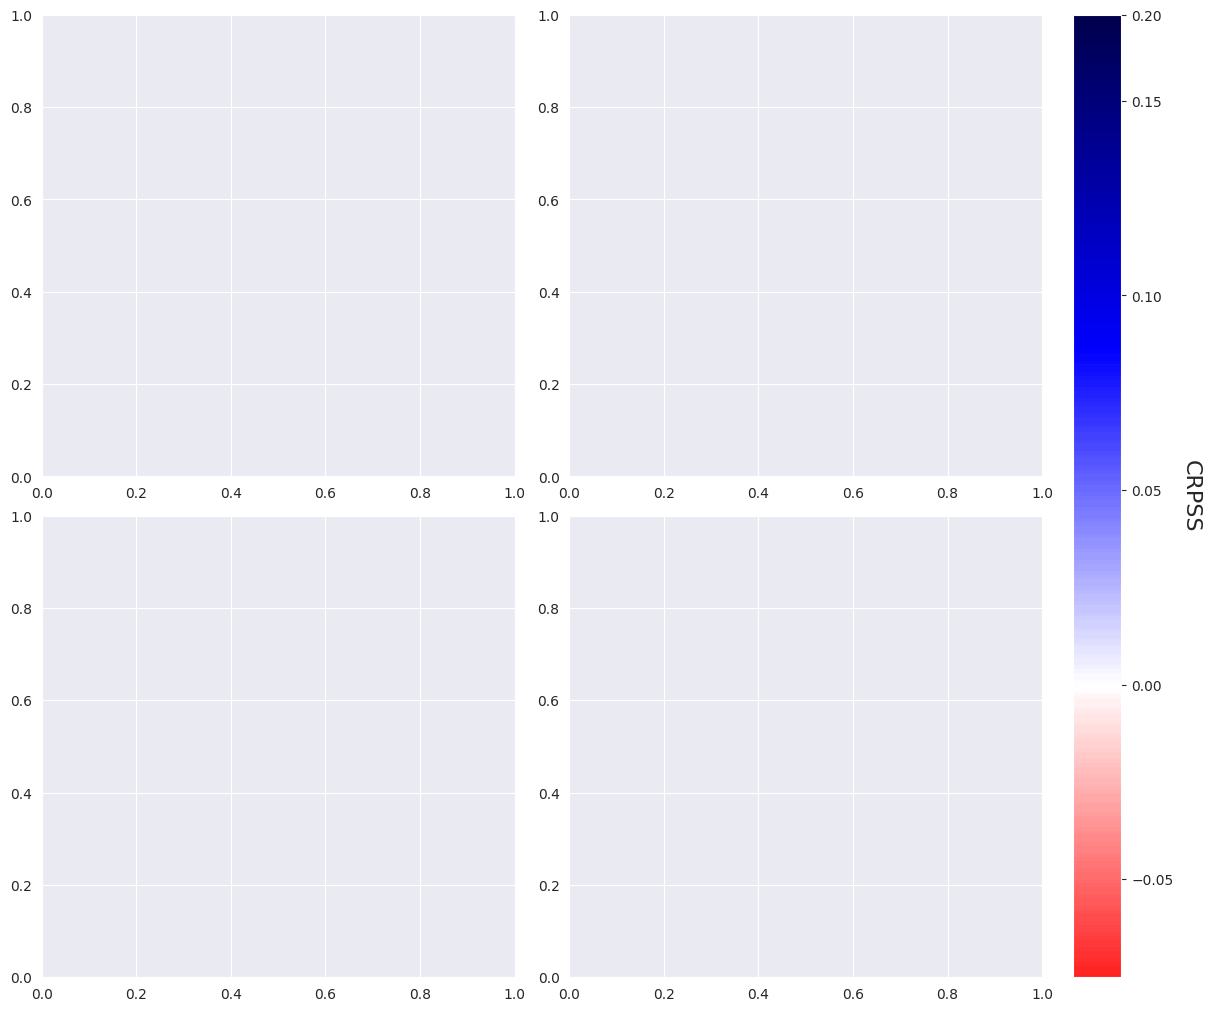

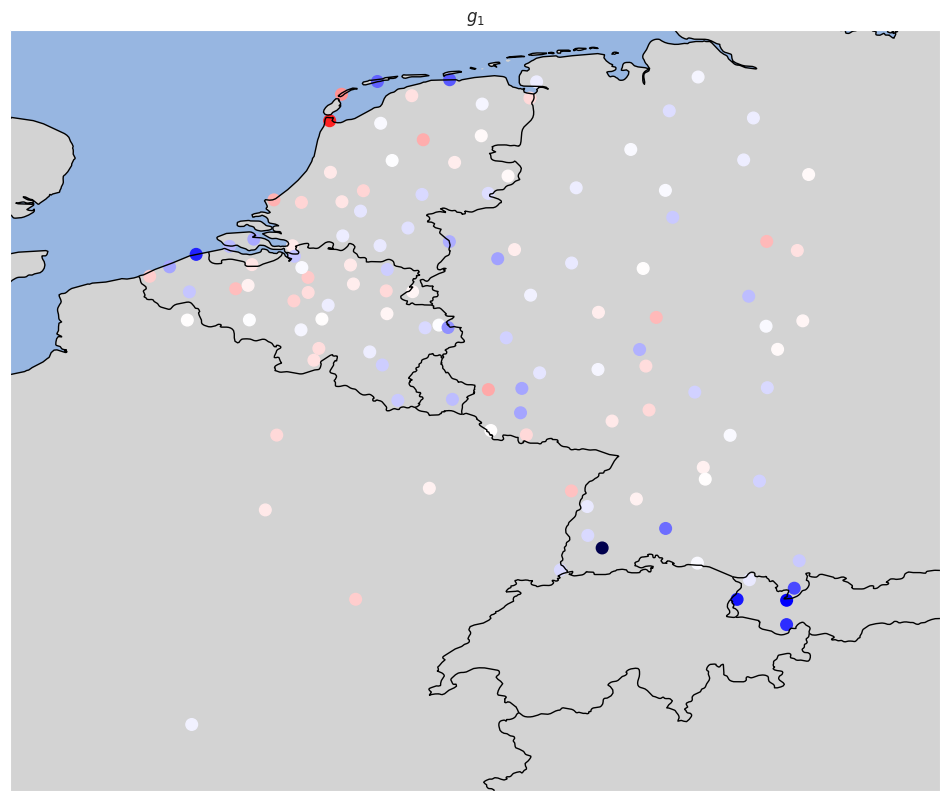

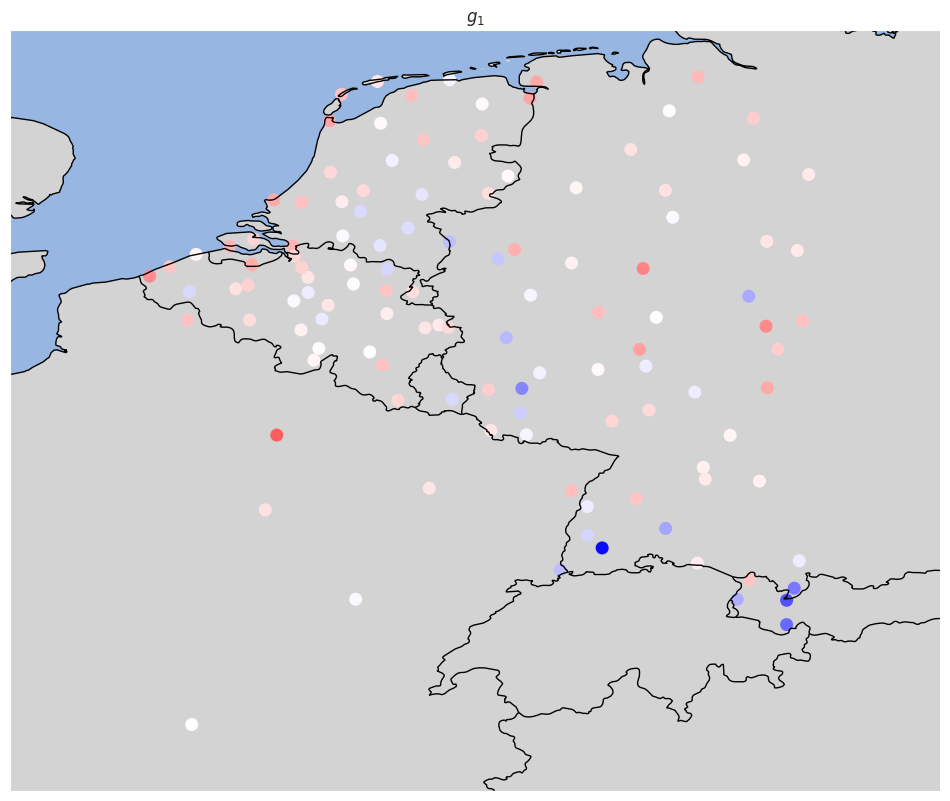

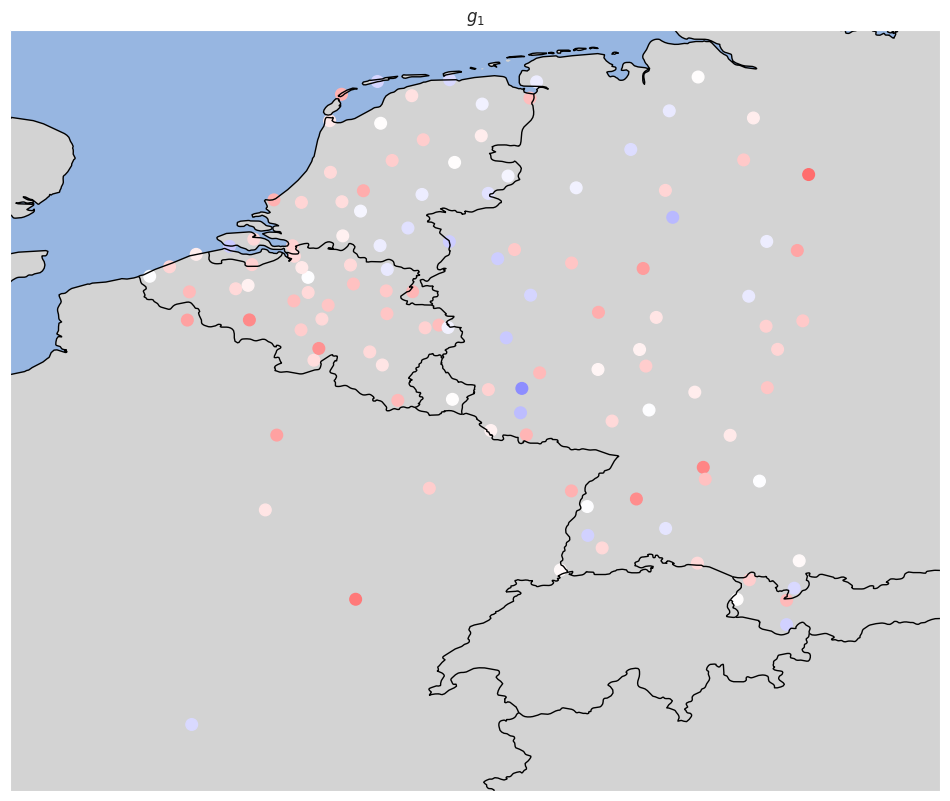

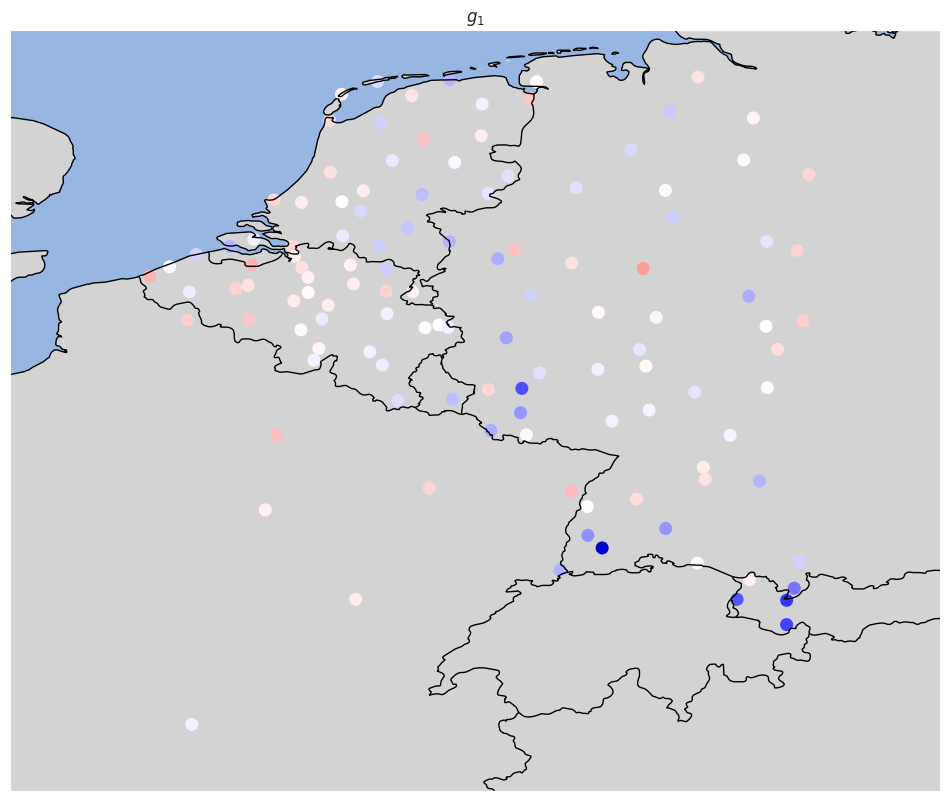

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
axs = axs.flatten()  # flatten for easy iteration

for i, ax in enumerate(axs):
    # Plot on each axis
    ax = plot_map()
    # plot = ax.scatter(stations['lon'], stations['lat'], c=stations['crpss'], cmap=cmap, s=70, norm=norm)
    sc = ax.scatter(
        stations_list[i]['lon'],
        stations_list[i]['lat'],
        c=stations_list[i]['crpss'],
        cmap=cmap,
        s=70,
        norm=norm
    )
    ax.set_title(r'$g_1$')
    ax.set_aspect('equal')

# Add a single colorbar on the right spanning all rows
# Passing all axes to 'ax' argument to span colorbar over them
cbar = fig.colorbar(sm_nodes, ax=axs, location='right', fraction=0.05, pad=0.02)
cbar.set_label('CRPSS', rotation=270, labelpad=20, fontsize=16)

plt.show()

## Compare two GNN CRPS

In [13]:
LEADTIME = "24h"
DATASET = "rf"
GRAPH1 = "g5"
GRAPH2 = "g1" # baseline graph (eq. to DRN)


model1 = pd.read_csv(f"leas_trained_models/sum_stats_{LEADTIME}/{GRAPH1}_{LEADTIME}/{DATASET}_{GRAPH1}_{LEADTIME}_results.csv")
model2 = pd.read_csv(f"leas_trained_models/sum_stats_{LEADTIME}/{GRAPH2}_{LEADTIME}/{DATASET}_{GRAPH2}_{LEADTIME}_results.csv")
model1["t2m"] = model1["t2m"] + 273.15
model1["mu"] = model1["mu"] + 273.15
model2["t2m"] = model2["t2m"] + 273.15
model2["mu"] = model2["mu"] + 273.15
model1 = model1.dropna(axis=0)
model2 = model2.dropna(axis=0)
dfs = load_dataframes(leadtime=LEADTIME)
targets = dfs[f"test_{DATASET}"][1].dropna(axis=0)

[INFO] Dataframes exist. Will load pandas dataframes.


In [77]:
targets[f"crps_GNN_{GRAPH1}"] = crps_no_avg(torch.tensor(model1[["mu", "sigma"]].to_numpy()), torch.tensor(model1["t2m"].to_numpy())).flatten().numpy()
targets[f"crps_GNN_{GRAPH2}"] = crps_no_avg(torch.tensor(model2[["mu", "sigma"]].to_numpy()), torch.tensor(model2["t2m"].to_numpy())).flatten().numpy()
targets

/tmp/ipykernel_3986828/2811033369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets[f"crps_GNN_{GRAPH1}"] = crps_no_avg(torch.tensor(model1[["mu", "sigma"]].to_numpy()), torch.tensor(model1["t2m"].to_numpy())).flatten().numpy()
/tmp/ipykernel_3986828/2811033369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets[f"crps_GNN_{GRAPH2}"] = crps_no_avg(torch.tensor(model2[["mu", "sigma"]].to_numpy()), torch.tensor(model2["t2m"].to_numpy())).flatten().numpy()


,time,station_id,t2m,crps_GNN_g5,crps_GNN_g1
0,2014-01-01,0,279.35,0.336423,0.591565
1,2014-01-01,1,279.55,0.957534,0.889672
2,2014-01-01,2,277.85,1.716042,2.063743
3,2014-01-01,3,277.25,1.895720,1.914586
4,2014-01-01,4,279.35,1.284810,1.229703
...,...,...,...,...,...
87835,2017-12-31,115,280.65,0.533929,0.548405
87836,2017-12-31,116,275.75,3.869822,2.766065
87837,2017-12-31,117,284.65,1.383420,1.983239
87838,2017-12-31,118,278.05,0.546807,0.826723


In [78]:
station_crps = targets.groupby("station_id")[[f"crps_GNN_{GRAPH1}", f"crps_GNN_{GRAPH2}"]].mean().reset_index()
station_crps["crpss"] = 1 - (station_crps[f"crps_GNN_{GRAPH1}"] / station_crps[f"crps_GNN_{GRAPH2}"])
stations = dfs["stations"]
stations["station_id"] = np.arange(0, len(stations))
stations = pd.merge(left=stations, right=station_crps, on="station_id")

In [70]:
import matplotlib as mpl
class MidpointNormalize(mpl.colors.Normalize):
    """ From: https://matplotlib.org/users/colormapnorms.html"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...

        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)

        vlargest = max( abs( self.vmax - self.midpoint ), abs( self.vmin - self.midpoint ) )
        x, y = [ self.midpoint - vlargest, self.midpoint, self.midpoint + vlargest], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

<Figure size 1200x1000 with 0 Axes>

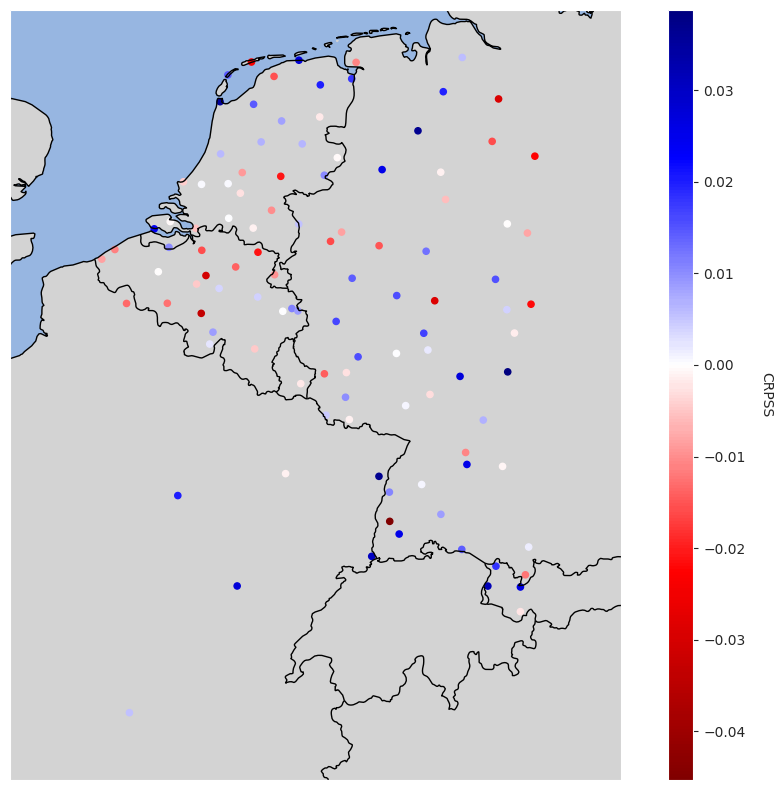

In [79]:
cmap = "seismic_r"
norm = MidpointNormalize(midpoint=0)

fig = plt.figure(figsize=(12, 10))
ax = plot_map()
plot = ax.scatter(stations['lon'], stations['lat'], c=stations['crpss'], cmap=cmap, s=20, norm=norm)

sm_nodes = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
colbar = plt.colorbar(sm_nodes, ax=ax, aspect=30)
colbar.set_ticks(colbar.get_ticks()[1:-1])
colbar.ax.set_ylabel('CRPSS', rotation=270, labelpad=20)

## Fix the aspect ratio of the map
# lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
# ax.set_aspect(1 / np.cos(np.radians(lat_center)))
plt.savefig(os.path.join(FIGUREPATH, f"crpss{LEADTIME}_{GRAPH2}basevs{GRAPH1}_{DATASET}.pdf"), bbox_inches = 'tight')